In [9]:
# Import the necessary tqdm versions
from tqdm import tqdm 
import sys


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
#from datasets import load_dataset, load

from pymicro.crystal.ebsd import OimScan
from pymicro.crystal.lattice import Lattice, CrystallinePhase, Symmetry
from pymicro.crystal.microstructure import Microstructure, Orientation
from pymicro.crystal.quaternion import Quaternion



In [10]:
# load the segmentation
grain_ids = np.squeeze(np.load('data/grains_ids_maps/19-B590.npy'))

In [11]:
grain_ids.shape

(500, 1000)

`ERC_IN718_25h_5h_1080C 5_4 Site 1 Map Data 14 .ctf` est pas CFC uniquement attention

`ERC_IN718 ... map 3.ctf` également

In [12]:



# directly import the EBSD data, here we chose not to take the confidence index into account
m = Microstructure.from_ebsd('data/raw_ebsd_scans/19-B590.ctf',  
                             grain_ids=grain_ids)



0 phases found in the data set
new phase added: unknown
19-B590 .ctf
using ref_frame 2
symmetry was changed to Symmetry.cubic
adding phase Phase 1 (Ni-superalloy) 
	-- Lattice (Symmetry.cubic) a=0.357, b=0.357, c=0.357 alpha=90.0, beta=90.0, gamma=90.0
importing data from region [0, 500, 0, 1000]
using spatial reference frame for orientation data


changing orientation reference frame progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 496023/496023 [00:32<00:00, 15416.21it/s]




0 phases found in the data set
new phase added: Ni-superalloy
using existing segmentation containing 2205 grains, size is  (500, 1000)





creating new grains:  11%|███████████████                                                                                                                         | 245/2205 [00:45<06:05,  5.36it/s]


KeyboardInterrupt: 

In [ ]:
m.dilate_grains(dilation_steps=3, new_map_name='grain_map', update_microstructure_properties=True)

m.quats = np.load('data/quat_ebsd_maps/19-B590.npy')

In [ ]:
#m.dilate_grains(dilation_steps=3, new_map_name='grain_map', update_microstructure_properties=True)


In [ ]:
grain_ids_dilated = np.squeeze(m.get_grain_map())

In [13]:
def find(parent, i):
    if parent[i] == i:
        return i
    else:
        # Path compression heuristic
        parent[i] = find(parent, parent[i])
        return parent[i]

def union(parent, size, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)
    
    if xroot != yroot:
        # Always attach the smaller tree to the larger tree based on size
        if size[xroot] < size[yroot]:
            parent[xroot] = yroot
            size[yroot] += size[xroot]
        else:
            parent[yroot] = xroot
            size[xroot] += size[yroot]

def merge_twins(twins_pairs, grains_ids):
    parent = {}
    size = {}

    # Extract unique grain IDs from the 2D grains_ids map
    unique_grains = np.unique(grains_ids)

    # Initialize the parent and size for each unique grain ID
    for grain_id in unique_grains:
        parent[grain_id] = grain_id
        size[grain_id] = np.sum(grains_ids == grain_id)

    # Process each pair and union the sets
    for grain_id, neighbor_id in twins_pairs:
        union(parent, size, grain_id, neighbor_id)

    # Create a new grains_ids map by updating each pixel to its representative
    new_grains_ids_map = np.copy(grains_ids)
    for i in range(new_grains_ids_map.shape[0]):
        for j in range(new_grains_ids_map.shape[1]):
            new_grains_ids_map[i, j] = find(parent, new_grains_ids_map[i, j])

    return new_grains_ids_map

def are_twins(m, grain1_id, grain2_id):
    # Constants
    nu_0 = 15  # degrees
    Sigma = 3  # Sigma value for twinning, typically 3 for {111} in FCC

    # Compute the Brandon criterion tolerance
    nu_mis = nu_0 / np.sqrt(Sigma)

    # Retrieve orientation matrices for both grains
    grain1 = m.get_grain(grain1_id)
    grain2 = m.get_grain(grain2_id)

    # Compute disorientation
    disorientation_angle, mis_axis, _ = Orientation(m.get_grain(grain1_id).orientation_matrix()).disorientation(
        m.get_grain(grain2_id).orientation, crystal_structure=Symmetry.cubic
    )
    
    

    # Convert disorientation angle from radians to degrees
    theta_Sigma = np.degrees(disorientation_angle)

    # Twinning misorientation angle for {111} in FCC (60 degrees)
    theta_mis = 60

    # Check using Brandon criterion for the angle
    if abs(theta_Sigma - theta_mis) > nu_mis:
        return False

    # Check if the misorientation axis is close to the <111> direction
    axis_111 = np.array([1, 1, 1]) / np.sqrt(3)  # normalized <111> axis
    axis_111_neg = -axis_111  # also consider the negative direction

    # Check if the misorientation axis is close to the <111> axis or its negative
    axis_match = np.allclose(mis_axis, axis_111, atol=0.2) or np.allclose(mis_axis, axis_111_neg, atol=0.2)
    
    #if axis_match: print('mis_axis = ', mis_axis)

    return axis_match

def are_twins2(m, grain1_id, grain2_id):

    # Retrieve orientation matrices for both grains
    grain1 = m.get_grain(grain1_id)
    grain2 = m.get_grain(grain2_id)
    
    orientation1 = Orientation(m.get_grain(grain1_id).orientation_matrix())
    orientation2 = Orientation(m.get_grain(grain2_id).orientation_matrix())
    
    return is_sigma_3_twin(orientation1, orientation2)

In [14]:
def is_sigma_3_twin(orientation1, orientation2, crystal_structure=Symmetry.cubic):
    """Check if two orientations form a Σ3 twin relationship (60° rotation around <111> axis).

    :param orientation1: an instance of Orientation class
    :param orientation2: an instance of Orientation class
    :returns bool: True if the orientations form a Σ3 twin, False otherwise.
    """
    sigma_3_angle = np.pi / 3  # 60 degrees in radians
    sigma_3_axis = np.array([1, 1, 1]) / np.sqrt(3)  # <111> axis

    symmetries = crystal_structure.symmetry_operators()
    (gA, gB) = (orientation1.orientation_matrix(), orientation2.orientation_matrix())

    for (g1, g2) in [(gA, gB), (gB, gA)]:
        for j in range(symmetries.shape[0]):
            sym_j = symmetries[j]
            oj = np.dot(sym_j, g1)  # the crystal symmetry operator is left applied
            for i in range(symmetries.shape[0]):
                sym_i = symmetries[i]
                oi = np.dot(sym_i, g2)
                delta = np.dot(oi, oj.T)
                mis_angle = Orientation.misorientation_angle_from_delta(delta)
                mis_axis = Orientation.misorientation_axis_from_delta(delta)
                if np.isclose(mis_angle, sigma_3_angle, atol=np.deg2rad(15)) and np.allclose(mis_axis, sigma_3_axis, atol=0.02):
                    return True
    return False

In [ ]:
print('Searching for twins...')
twins_pairs=[]
for grain in tqdm(m.grains):
    grain_id=grain['idnumber']
    if not(grain_id==0):
        for neighbor_id in m.find_neighbors(grain_id):
            if not(neighbor_id==0):
                if are_twins2(m, grain_id, neighbor_id):
                    #print('grain: {} and neighbor: {} are twins'.format(grain_id, neighbor_id))
                    twins_pairs.append([grain_id, neighbor_id])

new_grain_ids = merge_twins(twins_pairs,grain_ids_dilated)

In [11]:
from grains_merge import plot_grain_ids, get_cmap

In [ ]:
(grain_ids==0).sum()

In [ ]:
(grain_ids_dilated==0).sum()

In [ ]:
cmap = get_cmap(grain_ids)
plt.figure(figsize=(15,15))
im = plt.imshow(grain_ids, cmap=cmap)
plt.axis('off')
plt.draw()

In [ ]:
cmap = get_cmap(grain_ids_dilated)
plt.figure(figsize=(15,15))
im = plt.imshow(grain_ids_dilated, cmap=cmap)
plt.axis('off')
plt.draw()

In [ ]:
cmap = get_cmap(new_grain_ids)
plt.figure(figsize=(15,15))
im = plt.imshow(new_grain_ids, cmap=cmap)
plt.axis('off')
plt.draw()

In [ ]:
cmap = get_cmap(new_grain_ids)
plt.figure(figsize=(15,15))
im = plt.imshow(new_grain_ids, cmap=cmap)
plt.axis('off')
plt.draw()

## Mean Orientation computation after Twins Removal

In [2]:

for fname in tqdm(os.listdir('data/quat_ebsd_maps/')):
    MEAN_ORIENTATIONS = dict() #keys are IDs, values are quaternions (np.array)

    if os.path.exists(os.path.join('data/mean_quats_maps_no_twins/',fname,)):
        print('mean after twins removal exists for: ', fname)
        continue


    if not(os.path.exists(os.path.join('data/grains_no_twins_ids_maps/',fname))):
        print('grain ids maps after twins removal not found for: ', fname)
        continue


    # load the segmentation
    grain_ids = np.squeeze(np.load(os.path.join('data/grains_ids_maps',fname)))
    grain_ids_no_twins = np.squeeze(np.load(os.path.join('data/grains_no_twins_ids_maps/',fname)))

    # directly import the EBSD data, here we chose not to take the confidence index into account
    m = Microstructure.from_ebsd(os.path.join('data/raw_ebsd_scans',
                                              fname.replace('.npy','.ctf')),  
                                 grain_ids=grain_ids)

    m.dilate_grains(dilation_steps=3, new_map_name='grain_map', update_microstructure_properties=True)
    grain_ids_dilated = np.squeeze(m.get_grain_map())

    m.quats = np.load(os.path.join('data/quat_ebsd_maps', fname))

    rods = Orientation.eu2ro(m.get_field('euler').reshape((m.get_grain_map().shape[0]*m.get_grain_map().shape[1], 3)))
    rods = rods.reshape((m.get_grain_map().shape[0],m.get_grain_map().shape[1], 3))
    m.set_orientation_map(rods)

    sym = m.get_phase(1).get_symmetry()
    for gid in np.unique(grain_ids_no_twins):
        if gid!=0:
            rods_gid = m.fz_grain_orientation_data(gid, plot=False, move_to_fz=True) #errror here
            mean_quat = Orientation.compute_mean_orientation(rods_gid, symmetry=sym).quat.quat
            MEAN_ORIENTATIONS[gid] = mean_quat

    # Initialize the new map with the desired shape (n, m, 4)
    new_map = np.zeros((grain_ids_no_twins.shape[0], grain_ids_no_twins.shape[1], 4))

    # Loop over the grain_ids_no_twins array and populate the new map
    for i in range(grain_ids_no_twins.shape[0]):
        for j in range(grain_ids_no_twins.shape[1]):
            grain_id = grain_ids_no_twins[i, j]
            new_map[i, j] = MEAN_ORIENTATIONS[grain_id]

    np.save(os.path.join('data/mean_quats_maps_no_twins/',fname), new_map)



  0%|                                                                                                                                                                                 | 0/7 [00:00<?, ?it/s]

0 phases found in the data set
new phase added: unknown
19-B591 .ctf
using ref_frame 2
symmetry was changed to Symmetry.cubic
adding phase Phase 1 (Ni-superalloy) 
	-- Lattice (Symmetry.cubic) a=0.357, b=0.357, c=0.357 alpha=90.0, beta=90.0, gamma=90.0
importing data from region [0, 500, 0, 1000]
using spatial reference frame for orientation data



changing orientation reference frame progress:  26%|████████████████████████████▋                                                                                | 131629/499302 [00:07<00:21, 16779.14it/s]


changing orientation reference frame progress:  53%|█████████████████████████████████████████████████████████▊                                                   | 264849/499302 [00:15<00:13, 17235.11it/s]


changing orientation reference frame progress:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 399644/499302 [00:23<00:05, 17287.13it/s]


changing orientation reference frame progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499302/499302 [00:29<00:00, 17002.82it/s]




0 phases found in the data set
new phase added: Ni-superalloy
using existing segmentation containing 3237 grains, size is  (500, 1000)






creating new grains:   7%|█████████▋                                                                                                                                     | 219/3237 [00:27<05:09,  9.76it/s]


creating new grains:  14%|████████████████████▍                                                                                                                          | 462/3237 [01:02<11:46,  3.93it/s]


creating new grains:  21%|██████████████████████████████▌                                                                                                                | 692/3237 [01:37<02:59, 14.15it/s]


creating new grains:  29%|█████████████████████████████████████████▍                                                                                                     | 939/3237 [02:10<05:18,  7.21it/s]


creating new grains:  37%|████████████████████████████████████████████████████▍                                                                                         | 1194/3237 [02:46<01:35, 21.36it/s]


creating new grains:  44%|███████████████████████████████████████████████████████████████▏                                                                              | 1439/3237 [03:15<03:43,  8.05it/s]


creating new grains:  51%|████████████████████████████████████████████████████████████████████████▋                                                                     | 1658/3237 [03:46<02:18, 11.40it/s]


creating new grains:  59%|███████████████████████████████████████████████████████████████████████████████████▏                                                          | 1897/3237 [04:19<01:58, 11.33it/s]


creating new grains:  66%|██████████████████████████████████████████████████████████████████████████████████████████████                                                | 2143/3237 [04:55<03:14,  5.62it/s]


creating new grains:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2433/3237 [05:32<00:38, 20.70it/s]


creating new grains:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2695/3237 [06:04<01:25,  6.32it/s]


creating new grains:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3001/3237 [06:36<00:12, 18.83it/s]


creating new grains: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3237/3237 [06:54<00:00,  7.82it/s]


440 voxels to replace
dilation step 1 done
176 voxels to replace
dilation step 2 done
56 voxels to replace
dilation step 3 done




computing grain bounding boxes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3236/3236 [00:00<00:00, 217557.63it/s]

updating phase map:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2313/3236 [00:07<00:03, 298.55it/s]


  0%|                                                                                                                                                                                 | 0/7 [08:06<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

In [4]:
orienation_map_debug = m.get_orientation_map()

In [6]:
orienation_map_debug is None

True

In [7]:
rods

array([[ -2.59976131,  -1.08997566,   0.47857583],
       [ -4.68359413,   4.55012123,  -0.11446869],
       [ -4.67446586,   4.53496939,  -0.10502306],
       ...,
       [-27.19334342, -24.92339124,   3.4212738 ],
       [-29.45210554, -27.06268362,   3.67538821],
       [-28.24459975, -25.95955209,   3.55655293]])

In [8]:
m.set_orientation_map(rods)

In [ ]:
from pymicro.crystal.microstructure import Orientation


In [ ]:
rods = rods.reshape((m.get_grain_map().shape[0],m.get_grain_map().shape[1], 3))


In [ ]:
m.set_orientation_map(rods)

In [ ]:
gid = 2
sym = m.get_phase(1).get_symmetry()
rods_gid = m.fz_grain_orientation_data(gid, plot=False, move_to_fz=True)

In [ ]:
mean_quat = Orientation.compute_mean_orientation(rods_gid, symmetry=sym).quat.quat

In [ ]:
mean_quat

In [ ]:
new_grain_ids.shape

In [ ]:
np.zeros((new_grain_ids.shape[0], new_grain_ids.shape[1], 4)).shape

## Validation after running the script

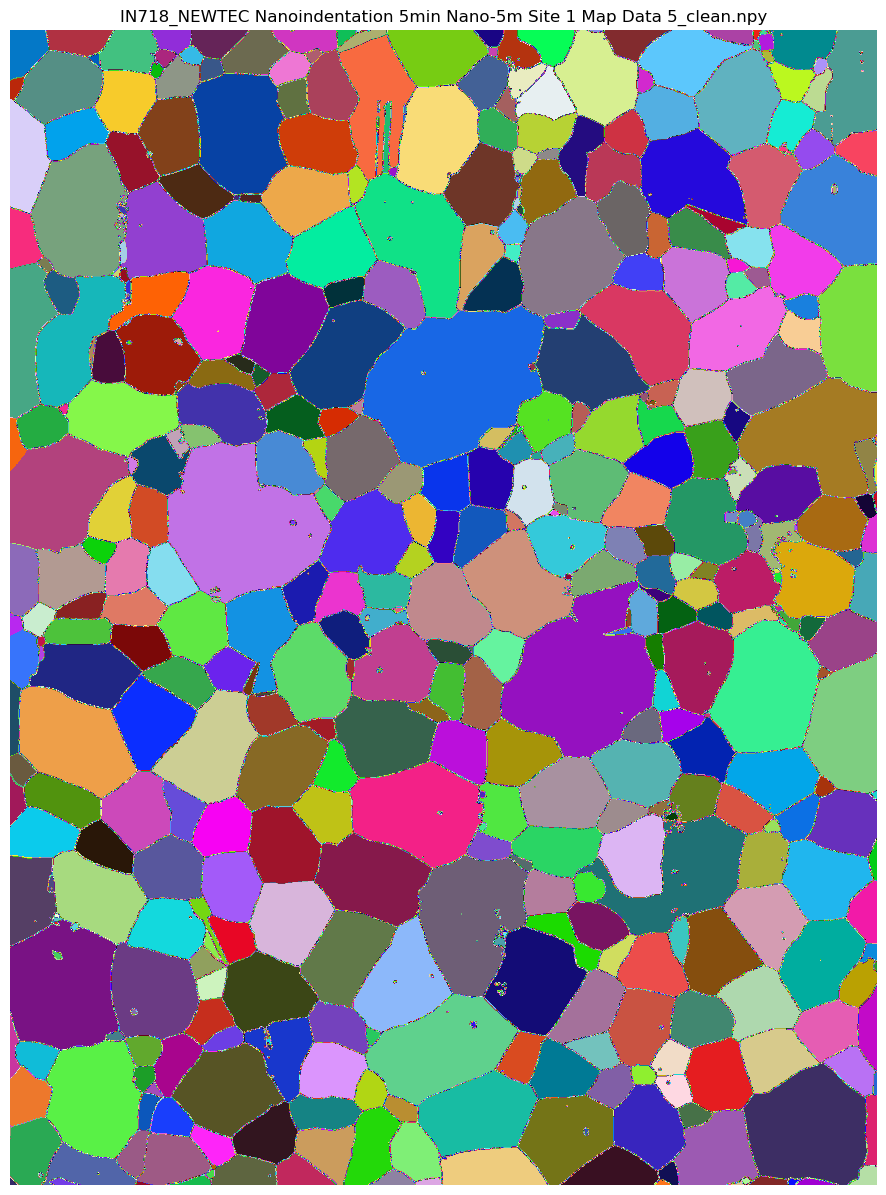

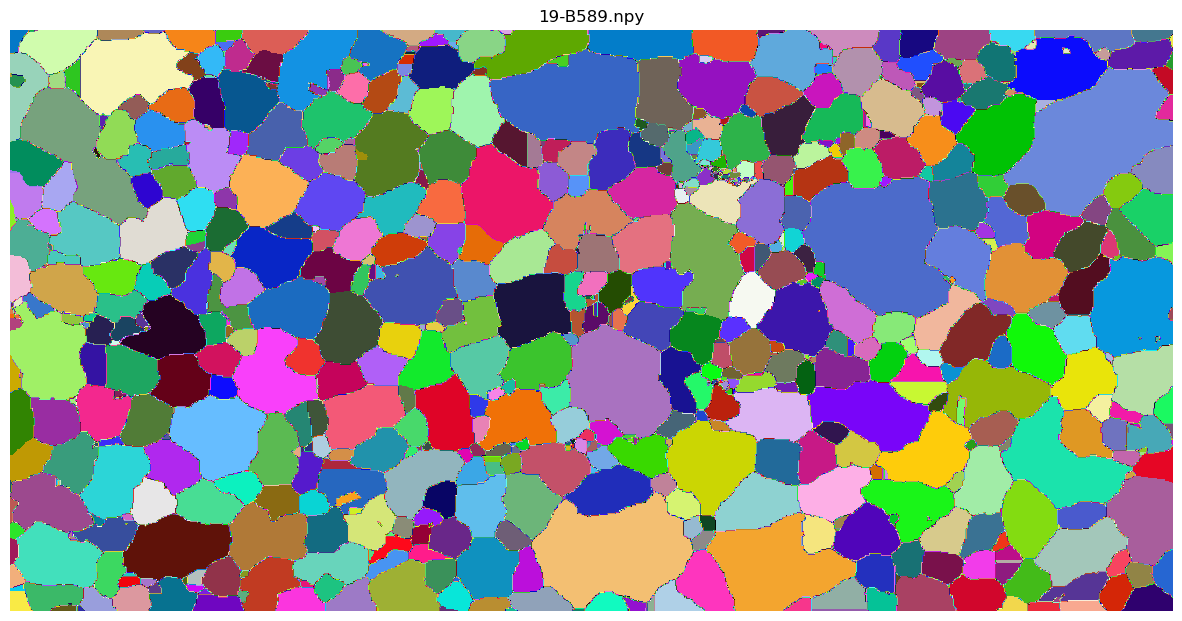

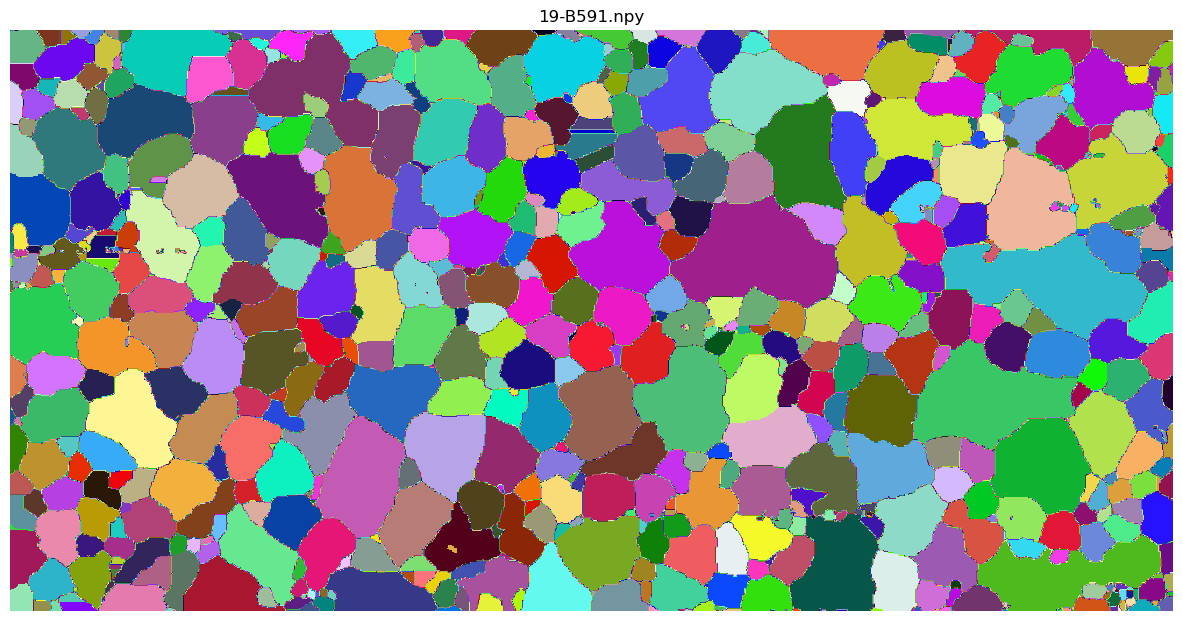

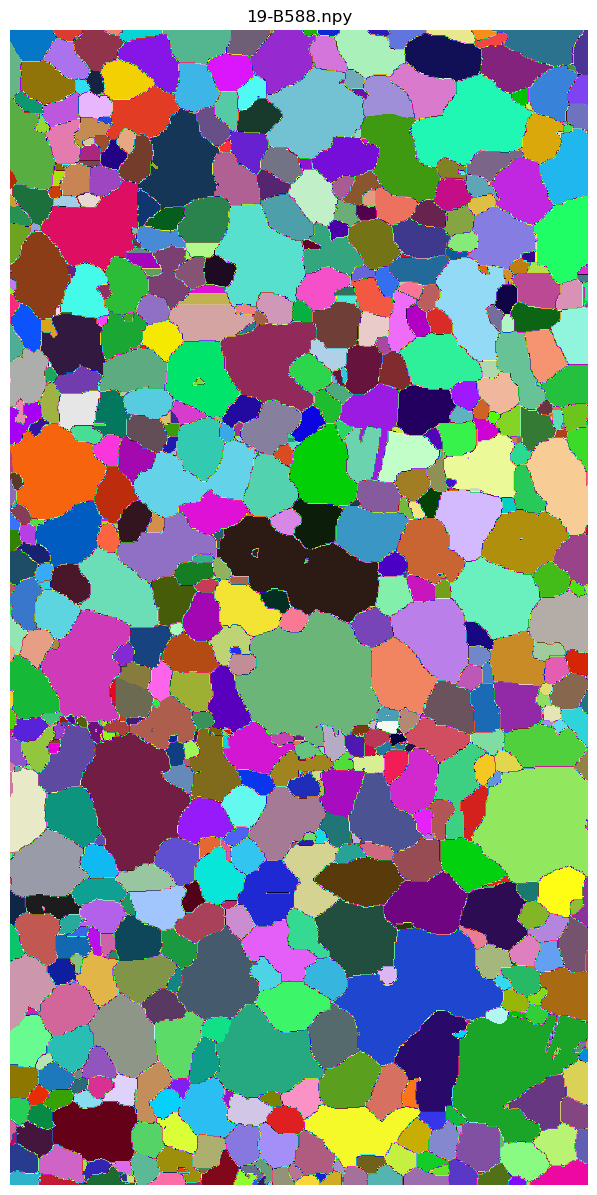

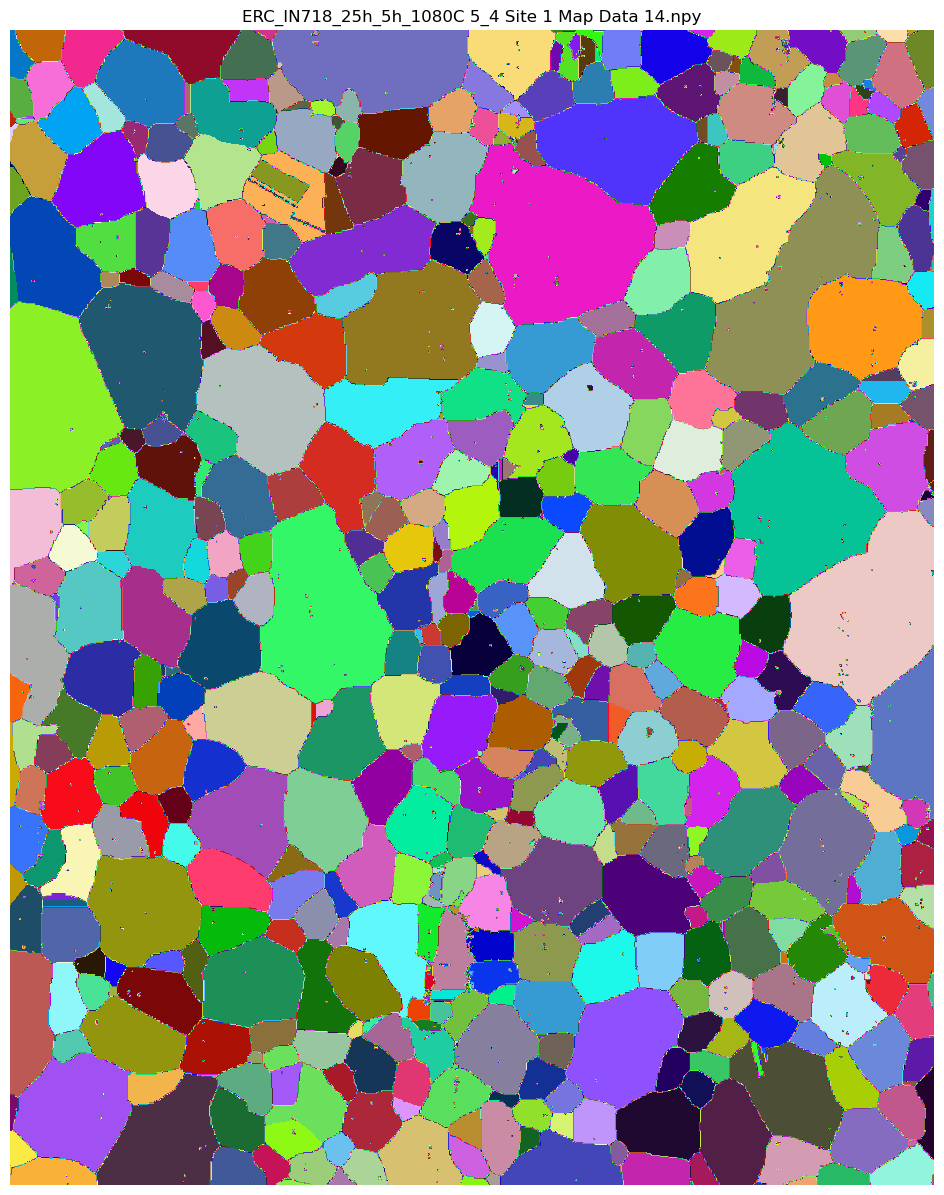

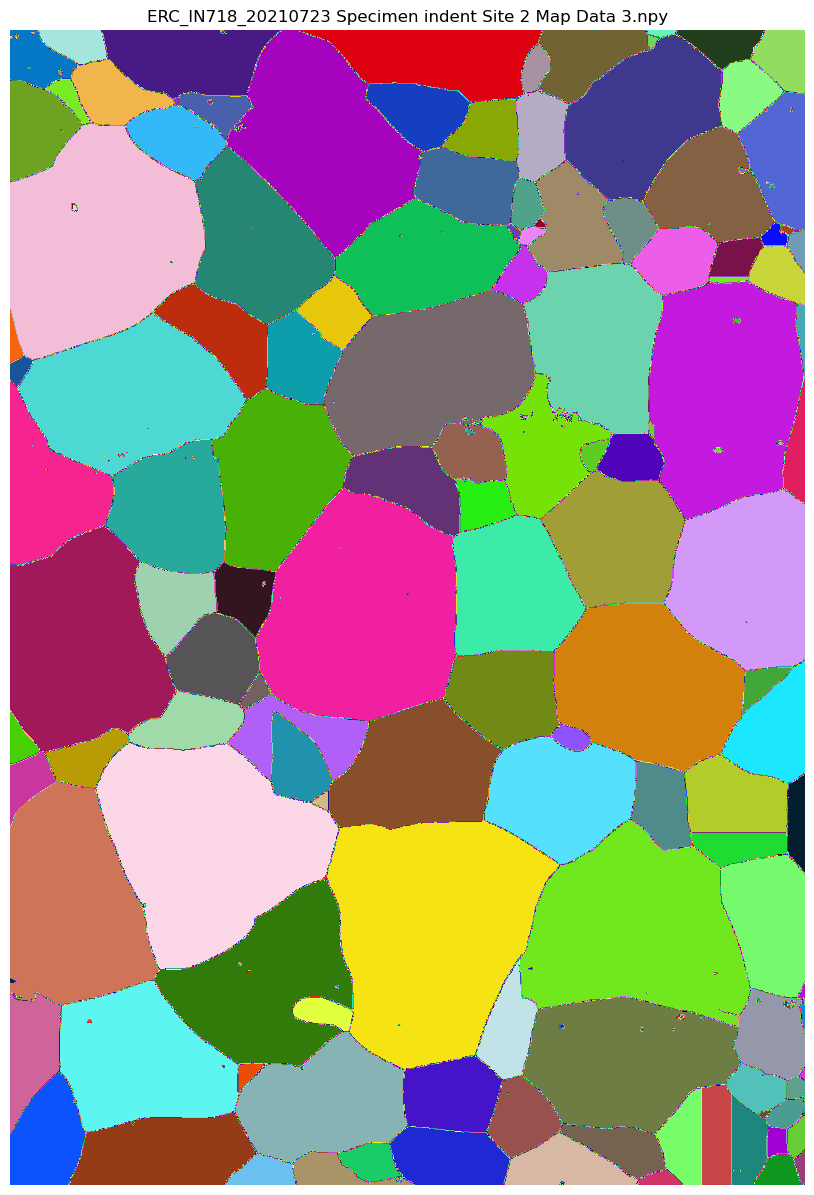

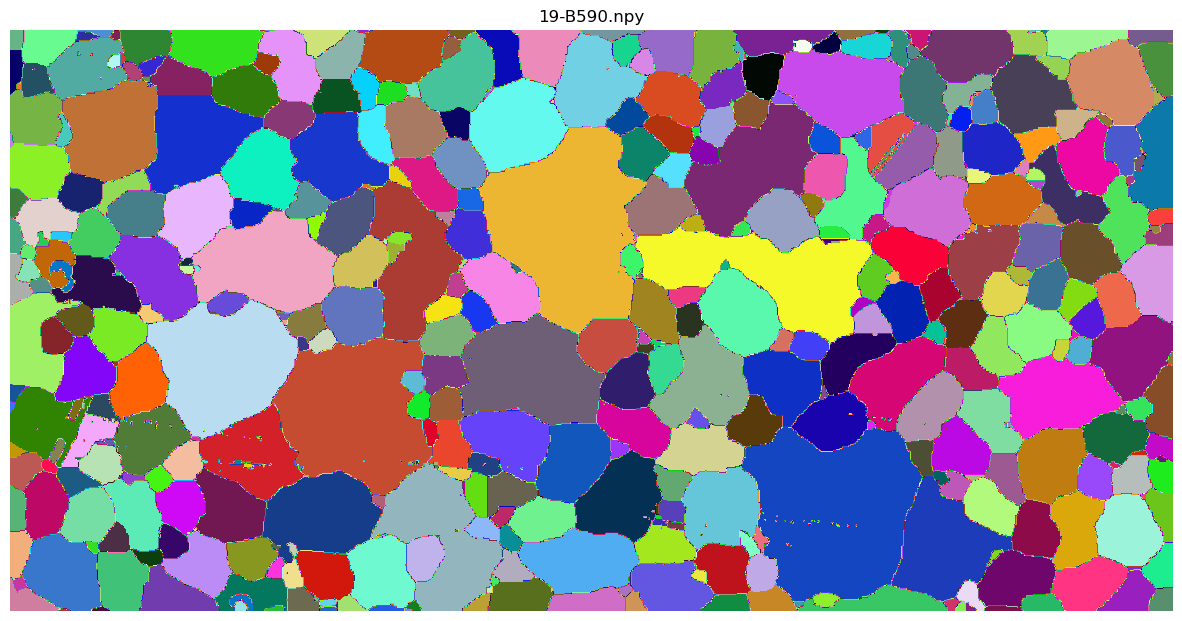

In [14]:
for fname in os.listdir('data/grains_no_twins_ids_maps/'):
    x=np.load('data/grains_no_twins_ids_maps/'+fname)

    cmap = get_cmap(x)
    plt.figure(figsize=(15,15))
    im = plt.imshow(x, cmap=cmap)
    plt.title(fname)
    plt.axis('off')
    plt.draw()